In [45]:
import json
import numpy as np
from scipy.integrate import solve_ivp, odeint
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import cm
import seaborn as sns

In [62]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.weight'] = 'bold'

In [64]:
# loading reaction rates for complex formation/dissociation
with open('reaction_rates.json') as f:
    kx = json.load(f)
f.close()
# loading degradation rates
with open('degradation_rates.json') as f:
    dr = json.load(f)
f.close()
# loading transcription rates
with open('transcription_rates.json') as f:
    tr = json.load(f)
f.close()
# loading hill coefficients of transcription
with open('hill_coefficients_of_transcription.json') as f:
    hcoeff = json.load(f)
f.close()
# loading import and export rates
with open('import_export_rates.json') as f:
    impexpr = json.load(f)
f.close()
# loading activation and inhibition rates
with open('activation_inhibition_rates.json') as f:
    air = json.load(f)
f.close()
# loading production rates
with open('production_rates.json') as f:
    pr = json.load(f)
f.close()
# loading transcription fold activation rates
with open('transcription_fold_activation_rates.json') as f:
    tfa = json.load(f)
f.close()
# loading volume proportions
with open('volume_proportions.json') as f:
    vi = json.load(f)
f.close()

In [75]:
# utility functions
def val(x): return x['value']

In [93]:
protein_mapping = {
    "x1": "Clock/Bmal_N",
    "x2": "Per/Cry_N^tot",
    "x5": "Rev-Erb_N",
    "x6": "Ror_N",
    "y1": "Per",
    "y2": "Cry",
    "y3": "Rev-Erb",
    "y4": "Ror",
    "y5": "Bmal",
    "y6": "Clock",
    "z1": "Cry_C",
    "z2": "Per_C^tot",
    "z4": "Per/Cry_C^tot",
    "z5": "Clock_C",
    "z6": "Rev-Erb_C",
    "z7": "Ror_C",
    "z8": "Bmal_C",
    "z9": "Clock/Bmal_C"
}

In [94]:
def circadian_clock(t, proteins):
    """
        function to compute the odes in the circadian clock model
        - these odes are based on the model proposed by Relogio et al. (2011) [1]
          and later modified by Hesse et al. (2021) [2]
        this is just the core clock which does not capture any interactions with external factors like drugs or stimuli (like light)
        TODO: these external factors would be incorporated in a separate function which computes the coupled odes for the factors

        References:
        [1] A. Rel´ogio, P. O. Westermark, T. Wallach, K. Schellenberg, A. Kramer, and H. Herzel, Tuning the mammalian circadian clock: robust synergy of two loops, PLoS computational biology, 7 (2011), p. e1002309.
        [2] J. Hesse, J. Martinelli, O. Aboumanify, A. Ballesta, and A. Rel´ogio, A mathematical model of the circadian clock and drug pharmacology to optimize irinotecan administration timing in colorectal cancer, Computational and Structural Biotechnology Journal, 19 (2021), pp. 5170–5183.
    """
    # unpacking the values of the proteins
    x1, x2, x5, x6 = proteins[:4]
    y1, y2, y3, y4, y5 = proteins[4:9]
    z1, z2, z4, z5, z6, z7, z8, z9 = proteins[9:17]
    y6 = proteins[17]
    ratio = val(vi['vc']) / val(vi['vn'])

    # odes for nuclear proteins and protein complexes
    dx1dt = val(impexpr['impr_z9']) * z9 - val(impexpr['expr_x1']) * x1 - val(dr['dr_x1']) * x1
    dx2dt = val(impexpr['impr_z4']) * z4 - val(impexpr['expr_x2']) * x2 - val(dr['dr_x2']) * x2
    dx5dt = val(impexpr['impr_z6']) * z6 - val(dr['dr_x5']) * x5
    dx6dt = val(impexpr['impr_z7']) * z7 - val(dr['dr_x6']) * x6

    # odes for core genes for the circadian clock
    dy1dthelper = (x1 / val(air['ar_y1']))**val(hcoeff['b'])
    dy1dt = val(tr['tr_y1']) * (1 + val(tfa['a']) * dy1dthelper) / (1 + dy1dthelper * (1 + (x2 / val(air['ir_y1']))**val(hcoeff['c']))) - val(dr['dr_y1']) * y1
    dy2dthelper = (x1 / val(air['ar_y2']))**val(hcoeff['e'])
    dy2dt = val(tr['tr_y2']) * (1 + val(tfa['d']) * dy2dthelper) / (1 + dy2dthelper * (1 + (x2 / val(air['ir_y2']))**val(hcoeff['f']))) * (1 / (1 + (x5 / val(air['ir_y21']))**val(hcoeff['f1']))) - val(dr['dr_y2']) * y2
    dy3dthelper = (x1 / val(air['ar_y3']))**val(hcoeff['b'])
    dy3dt = val(tr['tr_y3']) * (1 + val(tfa['g']) * dy3dthelper) / (1 + dy3dthelper * (1 + (x2 / val(air['ir_y3']))**val(hcoeff['c']))) - val(dr['dr_y3']) * y3
    dy4dthelper = (x1 / val(air['ar_y4']))**val(hcoeff['b'])
    dy4dt = val(tr['tr_y4']) * (1 + val(tfa['h']) * dy4dthelper) / (1 + dy4dthelper * (1 + (x2 / val(air['ir_y4']))**val(hcoeff['c']))) - val(dr['dr_y4']) * y4
    dy5dthelper = (x6 / val(air['ar_y5']))**val(hcoeff['b'])
    dy5dt = val(tr['tr_y5']) * (1 + val(tfa['i']) * dy5dthelper) / (1 + dy5dthelper + (x5 / val(air['ir_y5']))**val(hcoeff['c'])) - val(dr['dr_y5']) * y5
    dy6dthelper = (x6 / val(air['ar_y6']))**val(hcoeff['b'])
    dy6dt = val(tr['tr_y6']) * (1 + val(tfa['j']) * dy6dthelper) / (1 + dy6dthelper + (x5 / val(air['ir_y6']))**val(hcoeff['c'])) - val(dr['dr_y6']) * y6

    # odes for cytoplasmic proteins and protein complexes
    dz1dt = val(pr['pr_z1']) * y2 + val(kx['kd_z4']) * z4 - val(kx['kf_z4']) * z1 * z2 - val(dr['dr_z1']) * z1
    dz2dt = val(pr['pr_z2']) * y1 + val(kx['kd_z4']) * z4 - val(kx['kf_z4']) * z1 * z2 - val(dr['dr_z2']) * z2
    dz4dt = val(kx['kf_z4']) * z1 * z2 + ratio * val(impexpr['expr_x2']) * x2 - ratio * val(impexpr['impr_z4']) * z4 - val(kx['kd_z4']) * z4
    dz5dt = val(pr['pr_z5']) * y6 + val(kx['kd_z9']) * z9 - val(kx['kf_z9']) * z8 * z5 - val(dr['dr_z5']) * z5
    dz6dt = val(pr['pr_z6']) * y3 - ratio * val(impexpr['impr_z6']) * z6 - val(dr['dr_z6']) * z6
    dz7dt = val(pr['pr_z7']) * y4 - ratio * val(impexpr['impr_z7']) * z7 - val(dr['dr_z7']) * z7
    dz8dt = val(pr['pr_z8']) * y5 + val(kx['kd_z9']) * z9 - val(kx['kf_z9']) * z5 * z8 - val(dr['dr_z8']) * z8
    dz9dt = val(kx['kf_z9']) * z8 * z5 + ratio * val(impexpr['expr_x1']) * x1 - ratio * val(impexpr['impr_z9']) * z9 - val(kx['kd_z9']) * z9
    
    odes = [dx1dt, dx2dt, dx5dt, dx6dt, dy1dt, dy2dt, dy3dt, dy4dt, dy5dt, dz1dt, dz2dt, dz4dt, dz5dt, dz6dt, dz7dt, dz8dt, dz9dt, dy6dt]
    return odes

In [105]:
with open('initial_values.json') as f:
    init = json.load(f)
t_start = 0
t_end = 200
dt = 0.1
t_eval = np.linspace(t_start, t_end, int((t_end - t_start)/dt) + 1)

In [106]:
soln = solve_ivp(
    fun = circadian_clock,
    t_span = [t_start, t_end],
    y0 = list(init.values()),
    t_eval = t_eval,
    method = 'RK45',
    atol = 1e-12,
    rtol = 1e-12
)

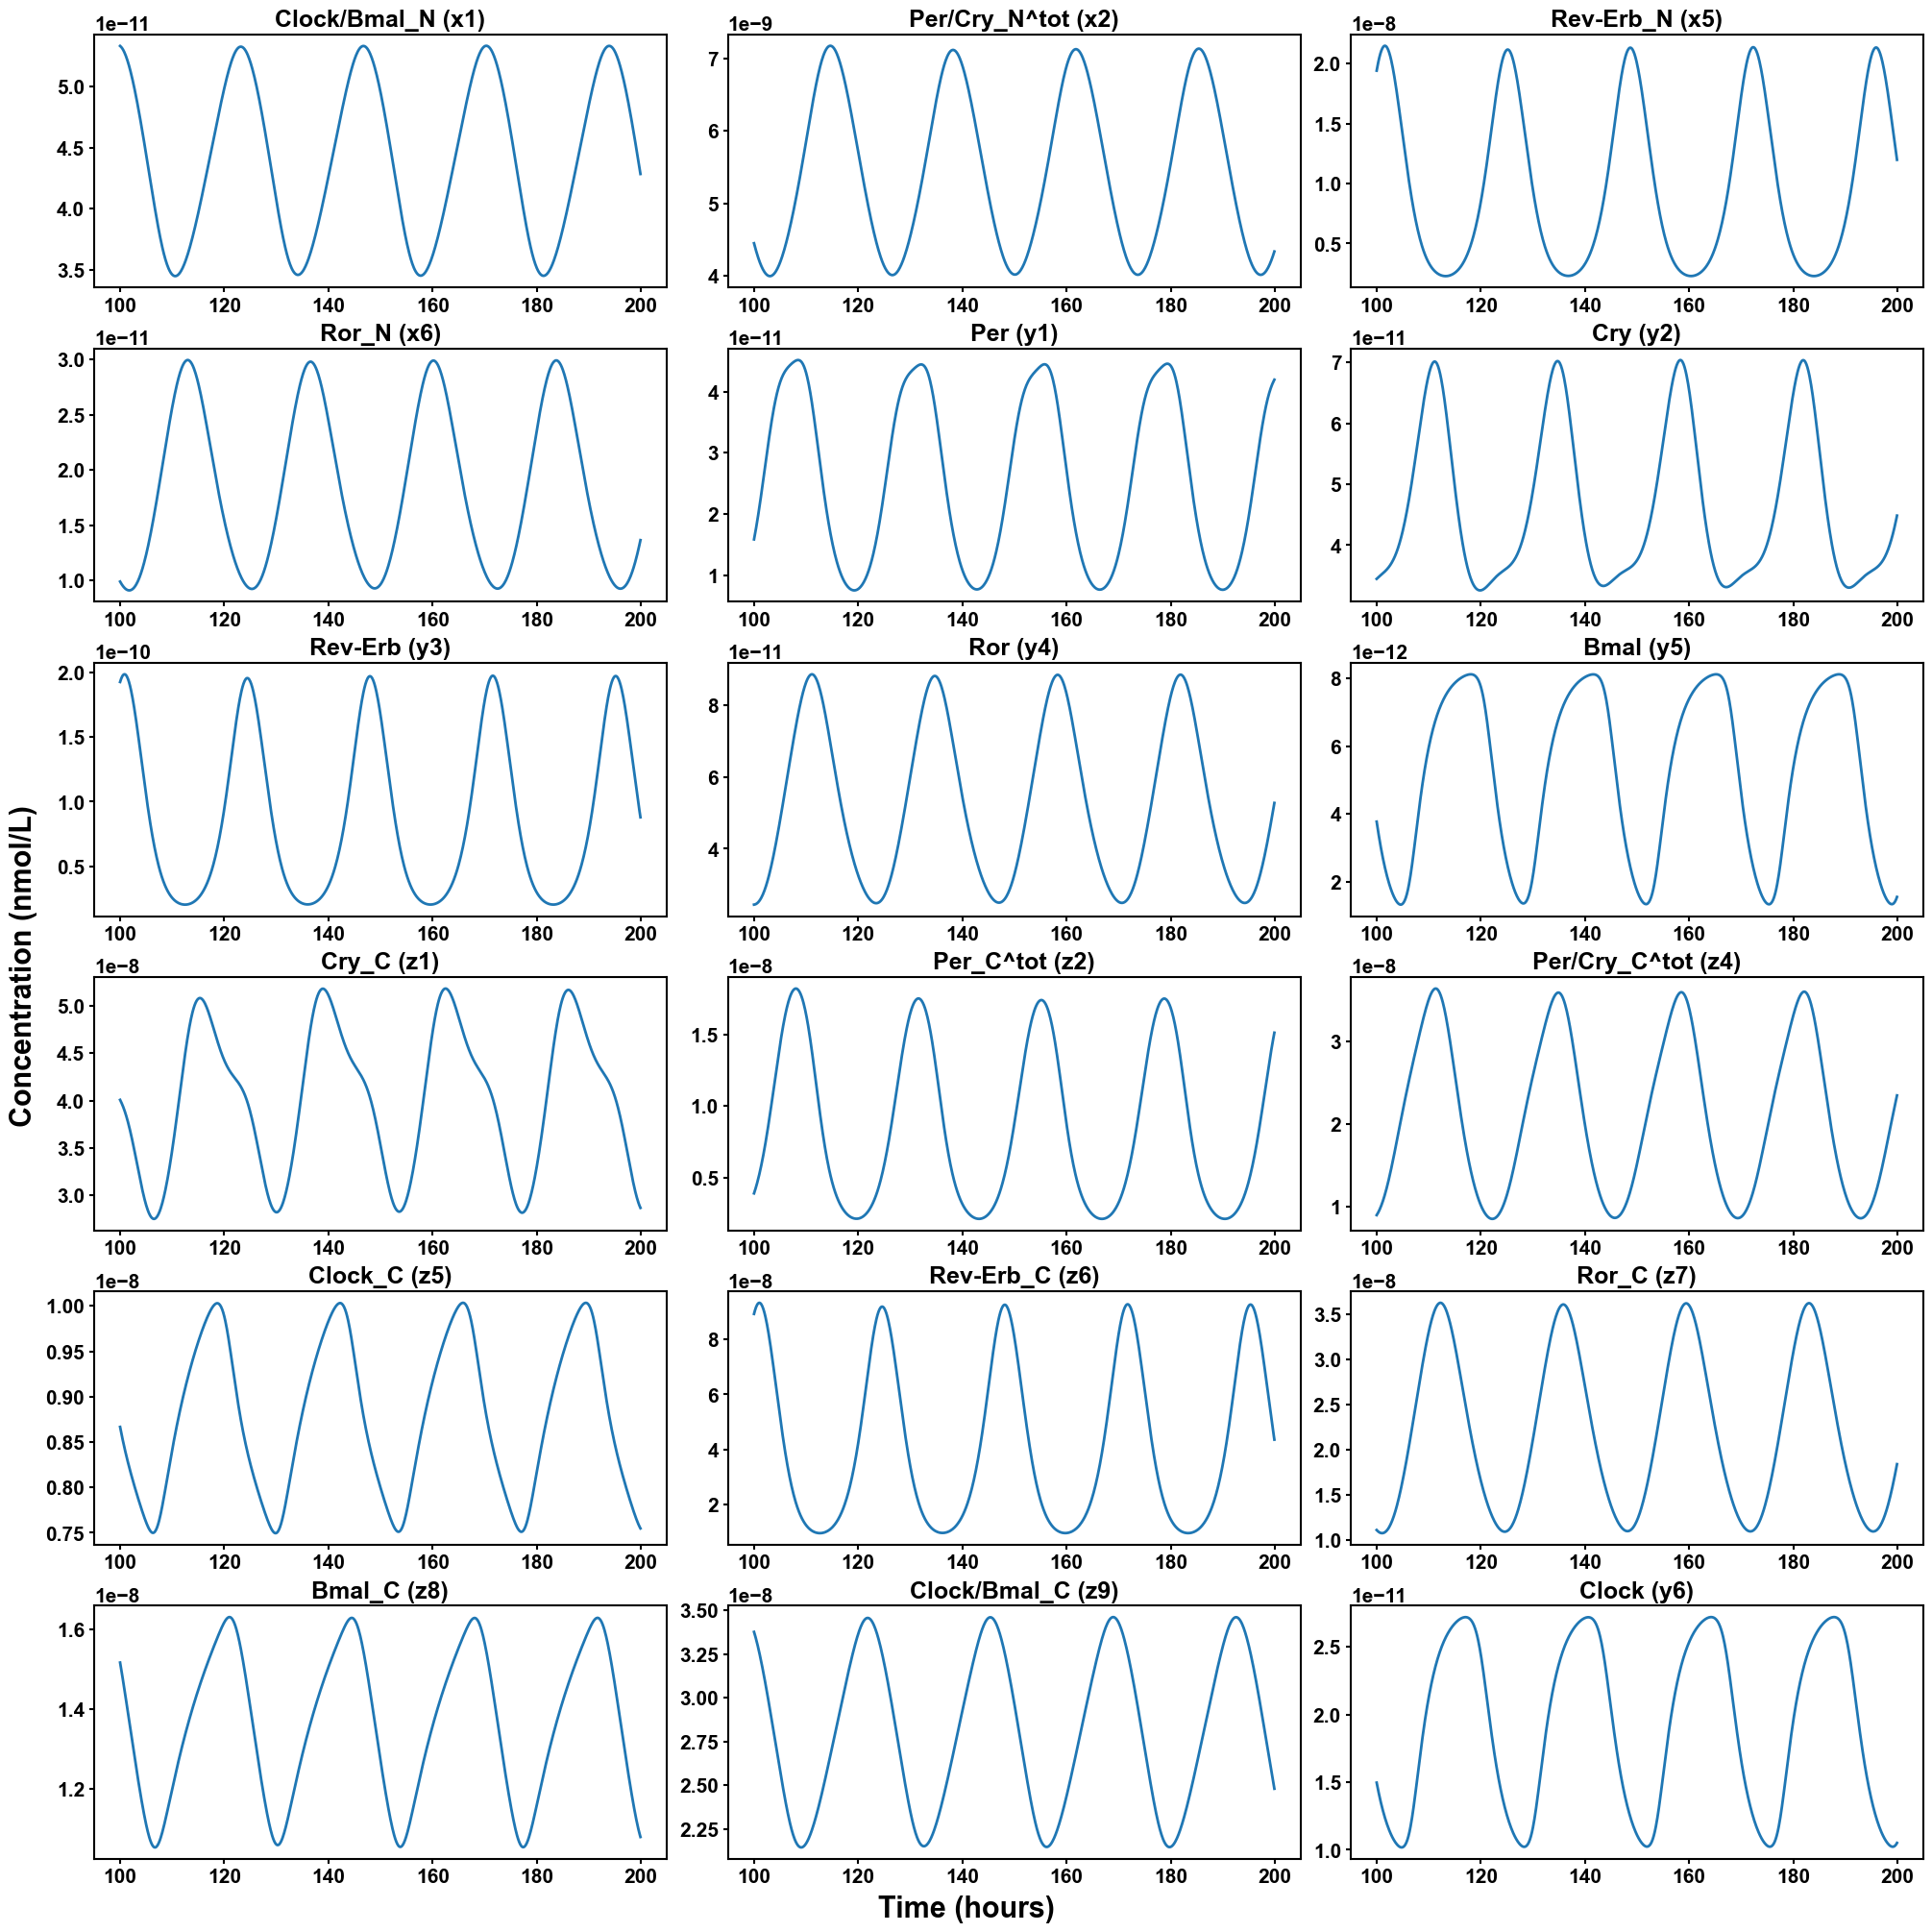

In [121]:
plt_start = int(100 / dt)
plt_end = int(t_end / dt)
fig, axes = plt.subplots(6, 3, figsize = (20,20), constrained_layout = True)
for i, ax in zip(range(len(init)), axes.flat):
    time = soln.t[plt_start:plt_end]
    prot = soln.y[i, plt_start:plt_end]
    ax.plot(time, prot, label = list(init.keys())[i], lw = 2)
    ax.tick_params(axis='both', which = 'major', labelsize = '15', width = 1.5)
    ax.yaxis.offsetText.set_fontsize(15)
    var = list(init.keys())[i]
    ax.set_title('{} ({})'.format(protein_mapping[var], var), fontsize = 18, weight = 'bold')
_ = fig.supylabel('Concentration (nmol/L)', fontsize = 22, weight = 'bold')
_ = fig.supxlabel('Time (hours)', fontsize = 22, weight = 'bold')
plt.savefig('circadian_clock_portion.png', bbox_inches = 'tight', pad_inches = 0.4, dpi = 300)

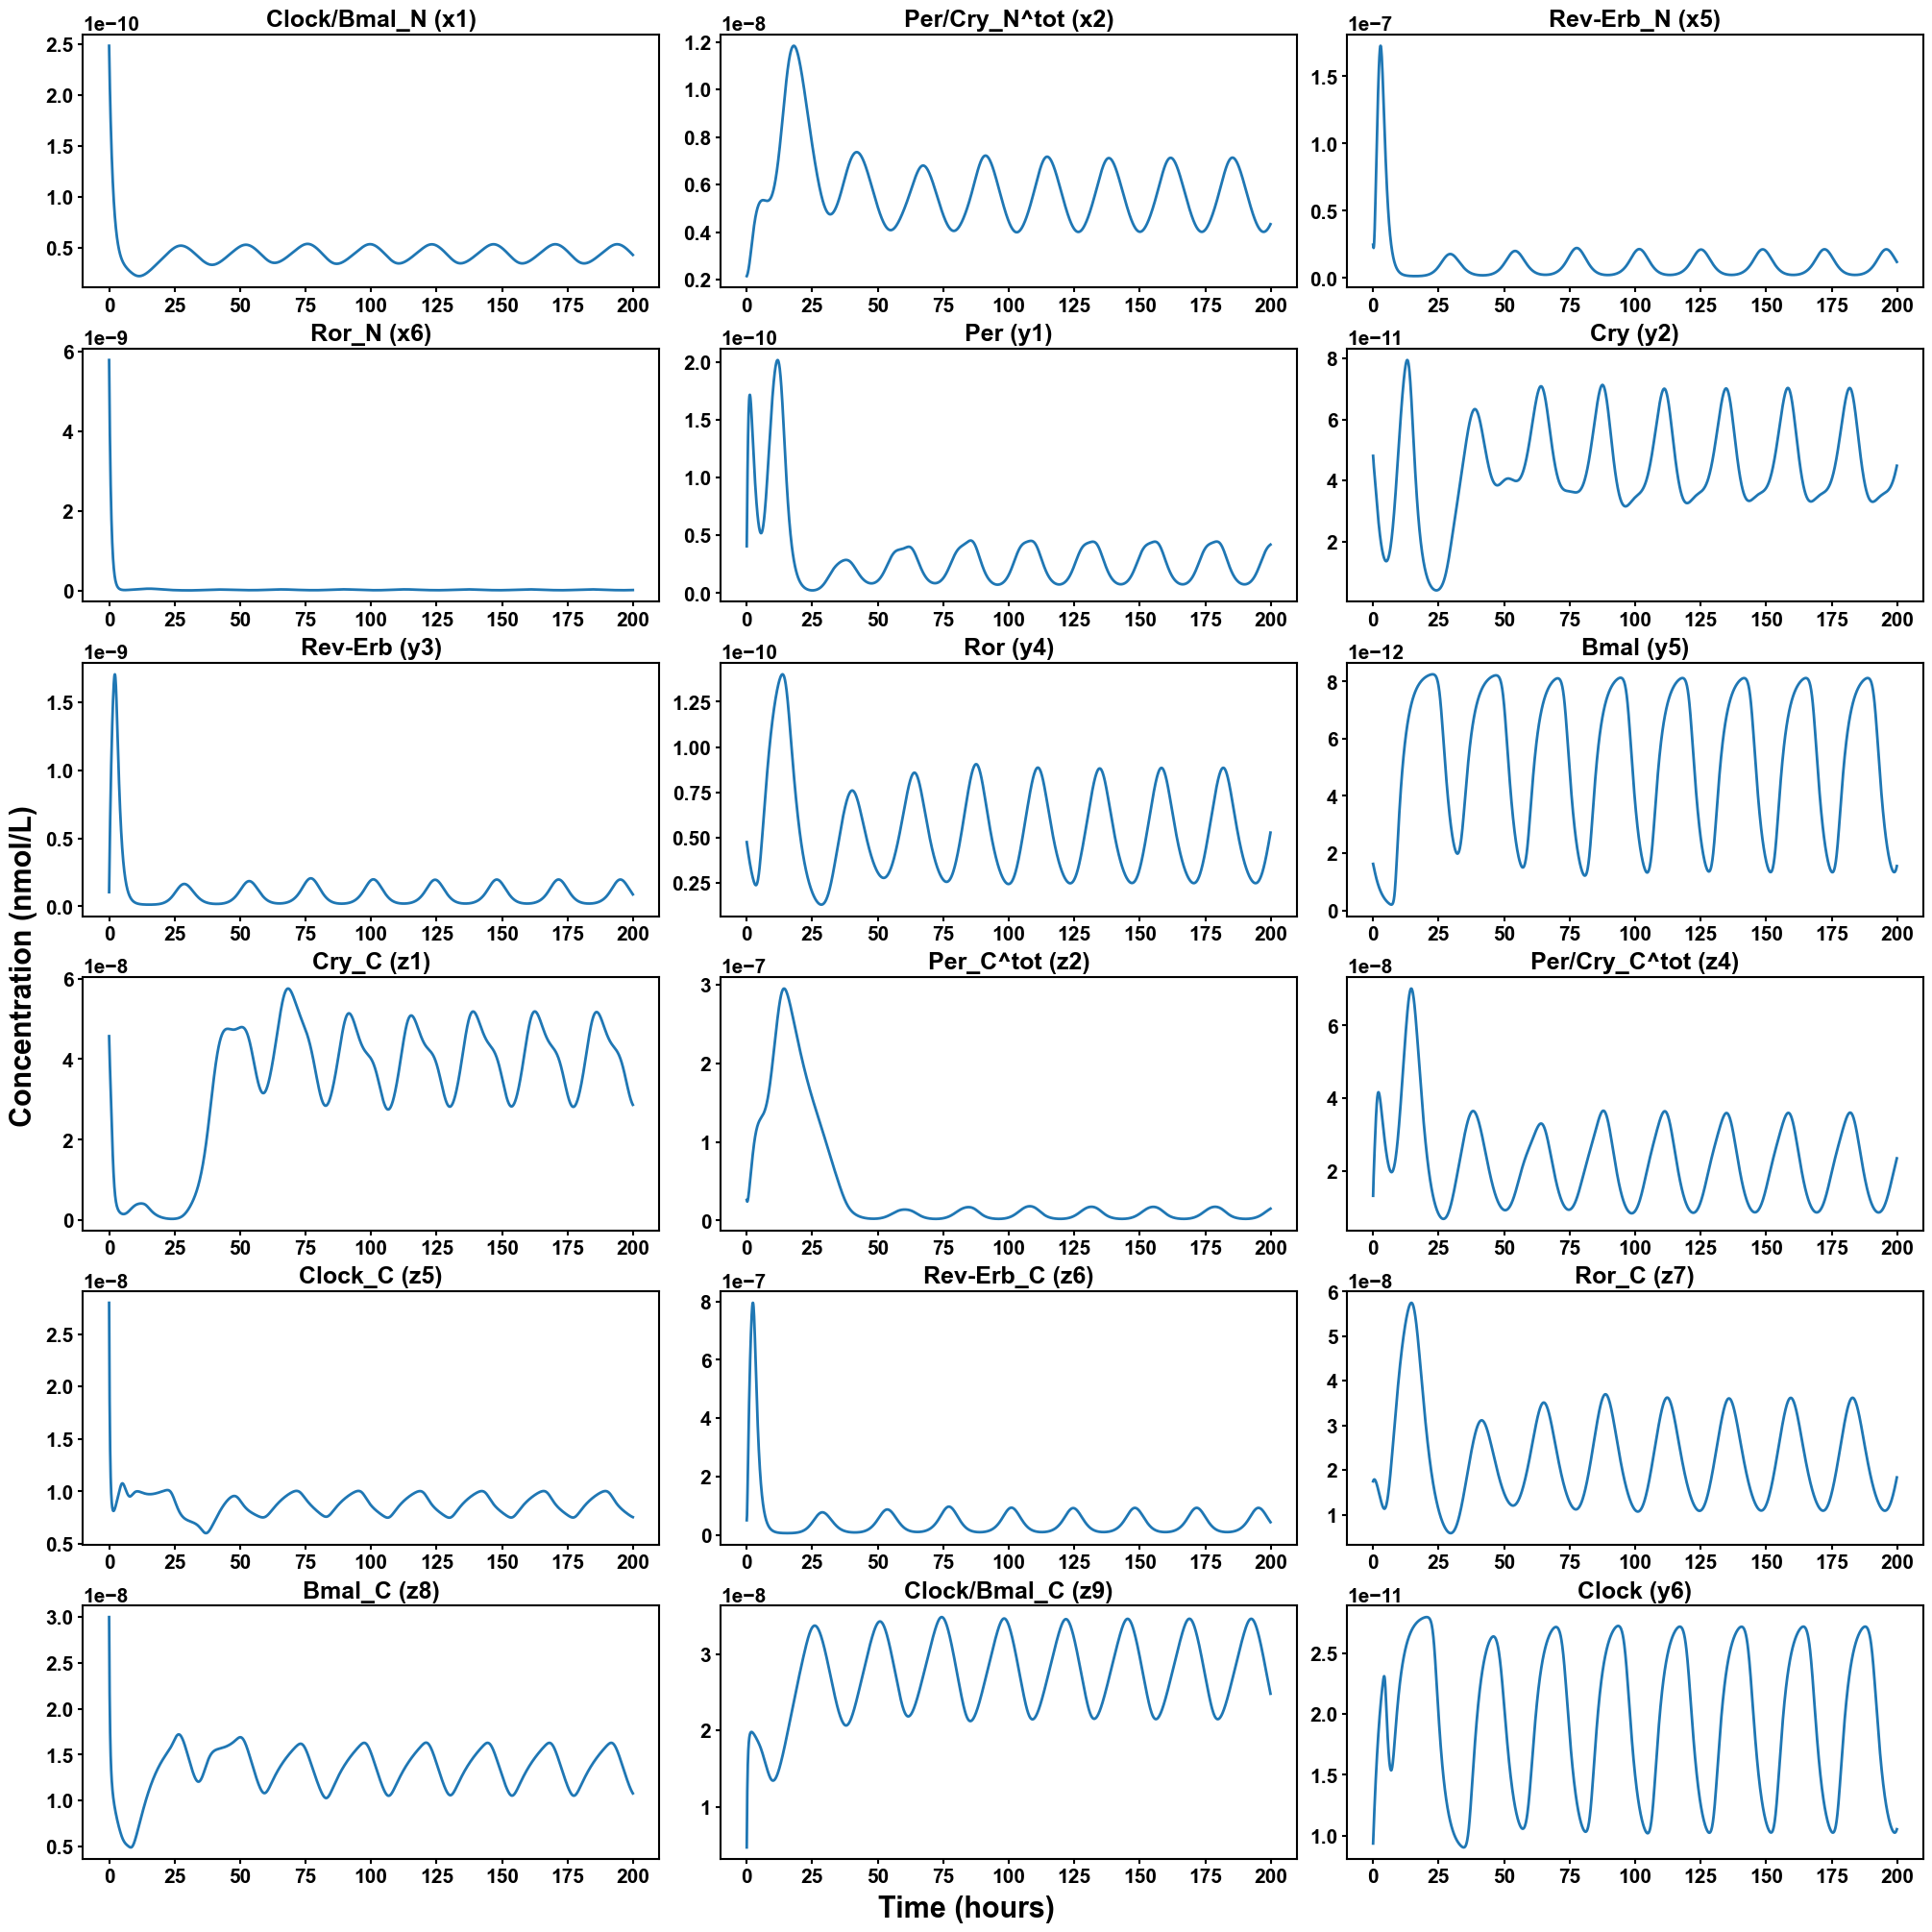

In [122]:
plt_start = int(t_start / dt)
plt_end = int(t_end / dt)
fig, axes = plt.subplots(6, 3, figsize = (20,20), constrained_layout = True)
for i, ax in zip(range(len(init)), axes.flat):
    time = soln.t[plt_start:plt_end]
    prot = soln.y[i, plt_start:plt_end]
    ax.plot(time, prot, label = list(init.keys())[i], lw = 2)
    ax.tick_params(axis='both', which = 'major', labelsize = '15', width = 1.5)
    ax.yaxis.offsetText.set_fontsize(15)
    var = list(init.keys())[i]
    ax.set_title('{} ({})'.format(protein_mapping[var], var), fontsize = 18, weight = 'bold')
_ = fig.supylabel('Concentration (nmol/L)', fontsize = 22, weight = 'bold')
_ = fig.supxlabel('Time (hours)', fontsize = 22, weight = 'bold')
plt.savefig('circadian_clock_entire_period.png', bbox_inches = 'tight', pad_inches = 0.4, dpi = 300)